# Tracking B 
---------------------------------------------


In this chapter, we explore the properties and an extension of the Kalman filter.

In [2]:
from IPython.core.display import HTML
import numpy as np
import matplotlib
import scipy
from scipy.stats import norm
from scipy.stats import binom
import pandas as pd
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
from matplotlib import pyplot as plt
import random
import math
from ipywidgets import *
import numpy.linalg
from IPython.display import display
from IPython.core.display import HTML
from notebook.nbextensions import enable_nbextension 
%matplotlib inline

print('The libraries loaded successfully')

The libraries loaded successfully




## Observability and the Kalman Filter

Intuitively, a system is **observable** if the observations are rich enough to track the state.

Consider the following trivial example:

\begin{eqnarray*}
X(n+1) &=& X(n) + V(n) \\
Y(n) &=& W(n)
\end{eqnarray*}
where $V(n)$ and $W(n)$ are independent zero-mean noise sequences with variances $\sigma^2_v$ and $\sigma_w^2$ and $E(X(0)) = 0, var(X(0)) = 1$.  

In this case, $Y^n = \{Y(0), \ldots, Y(n)\}$ is independent of $X(n)$.  
Hence $\bar X(n) := L[X(n) | Y^n] = E(X(n)) = 0$.
Also, 

$$var(X(n) - \bar X(n)) = var(X(n)) = var(X(0)) + var(V(0)) + \cdots + var(V(n-1))$$

$$~~~ = 1 + n \sigma_v^2.$$

Thus, the estimation error grows without bound. This is not surprising since the observation $Y(n)$ does not tell us anything about the value of $X(n)$.  Intuitively, one cannot observe $X(n)$ from the $Y(n)$.

The book explains that the system 

\begin{eqnarray*}
X(n+1) &=& AX(n) + V(n) \\
Y(n) &=& CX(n) + W(n)
\end{eqnarray*}

is **observable** if the null space of the **observability matrix**

$$\left[
\begin{array}{c}
C \\
CA \\
\vdots \\
CA^{d-1} 
\end{array}
\right] $$
is $\{\mathbf{0}\}$.  Here, $d$ is the dimension of $X(n)$. 

The book discusses the following result:

### Theorem (Kalman Filter for an Observable System)

If the system is observable, then $\Sigma_n$, the covariance of $X(n) - \bar X(n)$
is bounded.  Moreover, if $\Sigma_0 = 0$, then $\Sigma_n \to \Sigma$ and $K_n \to K$.

We illustrate this result on some examples below.


### Example 1: Unobservable Random Walk

This is an extreme and simplistic example, but it shows that if the observations are too poor, the error variance blows up.

$$X(n+1) = X(n) + V(n)$$

$$Y(n) = W(n) $$

$$var(V(n)) = varV, var(W(n)) = varW.$$


Here,

$$ A = 1 \mbox{ and } C = 0.$$

Thus, the dimension of $X(n)$ is $d = 1$ and the observability matrix is $C = 0$. The null space of this matrix is $\Re$ and the system is not observable. 

For this system, we plot $\sigma_n^2 = var(X_n - \bar X_n)$:

In [3]:
def dummy(varVd):
    global varV
    varV = float(varVd)

varVd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='2',description='varV',disabled=False)

z = widgets.interactive(dummy, varVd = varVd) 
display(z)

interactive(children=(Dropdown(description='varV', index=9, options=('0.2', '0.4', '0.6', '0.8', '1', '1.2', '…

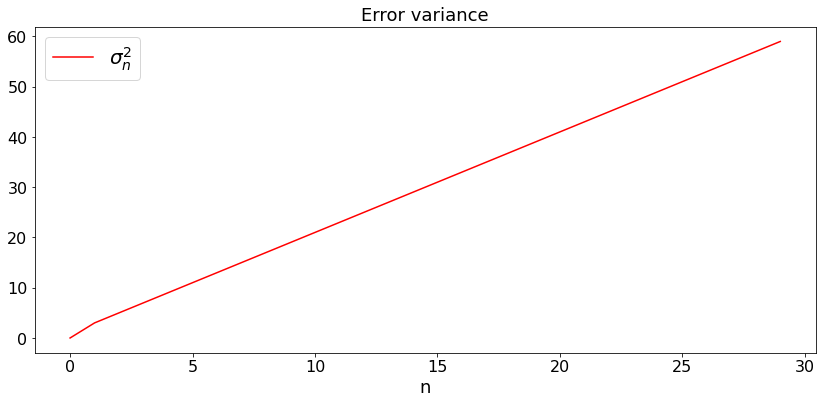

In [4]:
def KF6(v):  
    N = 30
    t = np.arange(0,N)
    sigma = np.arange(0.0,N)        
    for k in range(1,N):
        sigma[k] = k*v + 1
        
    plt.figure(figsize = (14,6))
    pls, = plt.plot(t,sigma,'red',label='$\sigma_n^2$')
    plt.legend()
    plt.title('Error variance')
    plt.xlabel('n')
    
KF6(varV)     

### Example 2: Observable Random Walk with unknown drift

$$X_1(n+1) = X_1(n) + X_2(n) + V(n)$$

$$X_2(n+1) = X_2(n) $$

$$Y(n) = X_1(n) + W(n) $$

$$var(V(n)) = varV, var(W(n)) = varW.$$


Here,

$$ A = \left[
\begin{array}{c c}
1 & 1 \\
0 & 1 
\end{array}
\right] \mbox{ and }
C = [1, 0].$$

Thus, the dimension of $X(n)$ is $d = 2$ and the observability matrix is 

$$\left[
\begin{array}{c}
C \\
CA 
\end{array}
\right] = \left[
\begin{array}{c c}
1 & 0 \\
1 & 1
\end{array}
\right]. $$

The null space of this matrix is $\mathbf{0}$.  Indeed, if some vector $\mathbf{x}$ is such that the 
matrix above multipled by $\mathbf{x}$ is equal to zero, then $x_1 = 0, x_1 + x_2 = 0$, so that 
$\mathbf{x} = \mathbf{0}$.  Thus, this system is observable.  Note that the output does not see the drift directly.  However, it can notice it indirectly.  Indeed, the difference between successivel values of $X_1(n)$  is an indication of the drift.  In fact, if there was no noise, this difference would be equal to the drift.

For this system, we plot $\Sigma_n(1,1)$ and $K_n$:

In [5]:
def dummy(varVd,varWd):
    global varV, varW
    varV, varW = float(varVd), float(varWd)

varVd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='2',description='varV',disabled=False)
varWd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='4',description='varW',disabled=False)

z = widgets.interactive(dummy, varVd = varVd, varWd = varWd) 
display(z)

interactive(children=(Dropdown(description='varV', index=9, options=('0.2', '0.4', '0.6', '0.8', '1', '1.2', '…

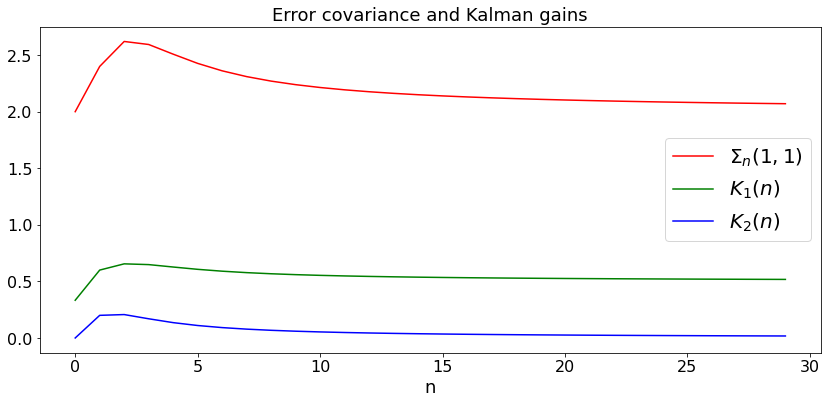

In [6]:
def KF7(v,w): 
    N = 30
    t = np.arange(0,N)
    X = np.zeros((2,N))
    Xb = np.zeros((2,N))
    Y = np.arange(0.0,N)
    sigma = np.arange(0.0,N)
    K1 = np.arange(0.0,N)
    K2 = np.arange(0.0,N)
    C = np.array([[1, 0]])
    S = np.array([[v, 0],[0,v]])
    K = np.dot(S,C.transpose())/(S[0,0] + w)
    A = np.array([[1, 1],[0,1]])    
    Sv = np.array([[v, 0],[0,0]])
    Sx = S
    Sw = w
    X[0,0] = 20
    X[1,0] = 1.2
    Xb[0,0] = 0
    Xb[1,0] = 1
    Y[0] = X[0,0] + w*np.random.normal()
    sigma[0] = v 
    K1[0] = K[0,0]
    K2[0] = K[1,0]
        
    for k in range(1,N):
        X[0,k]= (np.dot(A,X[:,k-1]))[0] + v**0.5*np.random.normal()
        X[1,k]= (np.dot(A,X[:,k-1]))[1] 
        Y[k] = X[0,k] + w**0.5*np.random.normal() 
        for i in range(2):
            Xb[i,k] = np.dot(A,Xb[:,k-1])[i] + (K*(Y[k]- Xb[0,k-1]))[i]
        S = np.dot(A,np.dot(Sx, A.T)) + Sv
        K = np.dot(S,C.T)/(S[0,0] + w)
        Sx = np.dot((np.identity(2) - np.dot(K,C)),S) 
        sigma[k] = Sx[0,0]
        K1[k] = K[0]
        K2[k] = K[1]
    plt.figure(figsize = (14,6))
    pls, = plt.plot(t,sigma,'red',label='$\Sigma_n(1,1)$')
    plt.legend()
    plK1, = plt.plot(t,K1,'green',label='$K_1(n)$')
    plt.legend()
    plK2, = plt.plot(t,K2,'blue', label ='$K_2(n)$')
    plt.legend()
    plt.title('Error covariance and Kalman gains')
    plt.xlabel('n')
    
KF7(varV,varW)
        

## Reachability and Kalman Filter

Intuitively, a system is **reachable** if the noise can drive its state to any arbitrary value.
Consider the random walk with an unknown but constant drift:

$$X_1(n+1) = X_1(n) + X_2(n) + V(n) $$

$$X_2(n+1) = X_2(n) $$

$$Y(n) = X_1(n) + W(n)$$

$$var(V(n)) = varV, var(W(n)) = varW.$$


The noise cannot modify the drift $X_2(n)$.  Ths, this system is not reachable.  

Consider the following system:

$$ X(n+1) = AX(n) + QV(n)$$

$$Y(n) = CX(n) + W(n)$$


where $V(n)$ are uncorrelated across time and $\Sigma_V = \mathbf{I}$.  That is, the components of $V(n)$ are uncorrelated and have variance $1$.
It is **reachable** if the following **reachability matrix**  is full rank:

$$[Q, AQ, A^2Q, \ldots, A^{d-1}Q] $$

where $d$ is the dimension of $X(n)$.  

For instance, in the case of the random walk with constant drift, 

$$ A = \left[
\begin{array}{c c}
1 & 1 \\
0 & 1 
\end{array}
\right] \mbox{ and }
Q = \left[
\begin{array}{c c}
1 & 0 \\
0 & 0 
\end{array}
\right].$$

Accordingly, the reachability matrix is as follows:

$$[Q, AQ] = \left[
\begin{array}{c c c c}
1 & 0 & 1 & 0\\
0 & 0 & 0 & 0
\end{array}
\right]. $$

The range of this matrix is $\{(x, 0)', x \in \Re$, which has dimension $1$.  This is a fancy way of saying that the noise cannot change $X_2(n)$.  Since the reachability matrix is not full rank, the system is not reachable.

The result about reachability is as follows.

### Theorem: (Kalman Filter for an Observable and Reachable System)

If the system is both observable and reachable, then the filter with a constant gain $K$ is such that the error convariance converges to the same limit $\Sigma$ as the Kalman filter with gain $K_n$. 

Note that for the filter with constant gain $K$, one has

$$S_n = A \Sigma_{n-1} A' + \Sigma_V$$

$$\Sigma_n = (I - KC)S_n.$$

That is,

$$\Sigma_n = (I - KC)[A \Sigma_{n-1} A' + \Sigma_V ]. \tag{8.1}$$


### Example 1:

We illustrate this latter theorem on the random walk with unknown drift example.  To do this, we run the equations (7.2)-(7.4) that give the updates of $K_n, S_n, \Sigma_n$ as we did in the previous example.  We then take the limiting value of $K$ and we run the equations (8.1).  $\Sigma_n^*(1,1)$ is the error covariance for $X_1(n)$ when using the limiting gain.

The example shows that using the limiting gain $K$ is not a good idea.  The reason is that the system is not reachable.

In [7]:
def dummy(varVd,varWd):
    global varV, varW
    varV, varW = float(varVd), float(varWd)

varVd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='2',description='varV',disabled=False)
varWd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='4',description='varW',disabled=False)

z = widgets.interactive(dummy, varVd = varVd, varWd = varWd) 
display(z)

interactive(children=(Dropdown(description='varV', index=9, options=('0.2', '0.4', '0.6', '0.8', '1', '1.2', '…

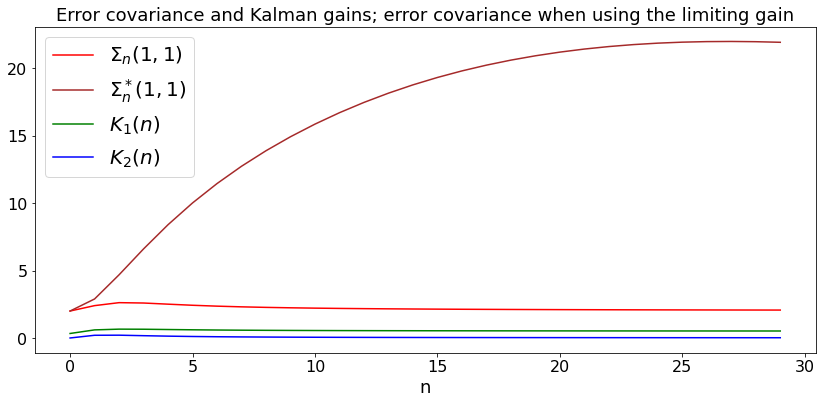

In [8]:
def KF8(v,w):  
    N = 30
    t = np.arange(0,N)
    sigma = np.arange(0.0,N)
    sigmab = np.arange(0.0,N)
    K1 = np.arange(0.0,N)
    K2 = np.arange(0.0,N)
    C = np.array([[1, 0]])
    S = np.array([[v, 0],[0,v]])
    Sb = np.array([[v, 0],[0,v]])
    K = np.dot(S,C.transpose())/(S[0,0] + w)
    Kb = np.dot(S,C.transpose())/(S[0,0] + w)
    A = np.array([[1, 1],[0,1]])    
    Sv = np.array([[v, 0],[0,0]])
    Sx = S
    Sxb = S
    Sw = w
    sigma[0] = v
    sigmab[0] = v
    K1[0] = K[0,0]
    K2[0] = K[1,0]

        
    for k in range(1,N):
        S = np.dot(A,np.dot(Sx, A.T)) + Sv
        K = np.dot(S,C.T)/(S[0,0] + w)
        Sx = np.dot((np.identity(2) - np.dot(K,C)),S) 
        sigma[k] = Sx[0,0]
        K1[k] = K[0]
        K2[k] = K[1]
    Kb = K
    for k in range(1,N):
        Sb = np.dot(A,np.dot(Sxb, A.T)) + Sv
        Sxb = np.dot((np.identity(2) - np.dot(K,C)),Sb) 
        sigmab[k] = Sxb[0,0]
       
    plt.figure(figsize = (14,6))
    pls, = plt.plot(t,sigma,'red',label='$\Sigma_n(1,1)$')
    plt.legend()
    plsb, = plt.plot(t,sigmab,'brown',label='$\Sigma_n^*(1,1)$')
    plt.legend()
    plK1, = plt.plot(t,K1,'green',label='$K_1(n)$')
    plt.legend()
    plK2, = plt.plot(t,K2,'blue', label ='$K_2(n)$')
    plt.legend()
    plt.title('Error covariance and Kalman gains; error covariance when using the limiting gain')
    plt.xlabel('n')
    
KF8(varV,varW)   

### Example 2:

We now consider the random walk with unknown but changing drift.  Recall the system:

$$X_1(n+1) = X_1(n) + X_2(n) + V_1(n) $$

$$X_2(n+1) = X_2(n) + V_2(n)$$

$$Y(n) = X_1(n) + W(n)$$

$$var(V_1(n)) = varV1, var(V_2(n)) = varV2, var(W(n)) = varW.$$

For this system,

$$A = \left[
\begin{array}{c c}
1 & 1 \\
0 & 1
\end{array}
\right],
C = [0, 1], \mbox{ and } Q = \left[
\begin{array}{c c}
1 & 0 \\
0 & 1
\end{array}
\right]. $$

Accordingly, the observability matrix is 

$$\left[
\begin{array}{c}
C \\
CA 
\end{array}
\right] = \left[
\begin{array}{c c}
1 & 0 \\
1 & 1
\end{array}
\right], $$

so that the system is observable.  Also, the reachability matrix is

$$[Q, AQ] = \left[
\begin{array}{c c c c}
1 & 0 & 1 & 1\\
0 & 1 & 0 & 1
\end{array}
\right], $$

so that the system is also reachable.

As in the previous example, we compute the error covariance of the Kalman filter and that of the filter with the constant (limiting) gain.

In [9]:
def dummy(varV1d,varV2d,varWd):
    global varV1, varV2, varW
    varV1, varV2, varW = float(varV1d), float(varV2d),float(varWd)

varV1d = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='2',description='varV1',disabled=False)
varV2d = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='2',description='varV2',disabled=False)
varWd = widgets.Dropdown(options=['0.2', '0.4', '0.6', '0.8','1','1.2','1.4','1.6','1.8','2','2.2','2.4','2.6','2.8','3','3.2','3.4','3.6','3.8','4','4.2','4.4','4.6','4.8','5','5.2'],value='4',description='varW',disabled=False)

z = widgets.interactive(dummy, varV1d = varV1d, varV2d = varV2d, varWd = varWd) 
display(z)

interactive(children=(Dropdown(description='varV1', index=9, options=('0.2', '0.4', '0.6', '0.8', '1', '1.2', …

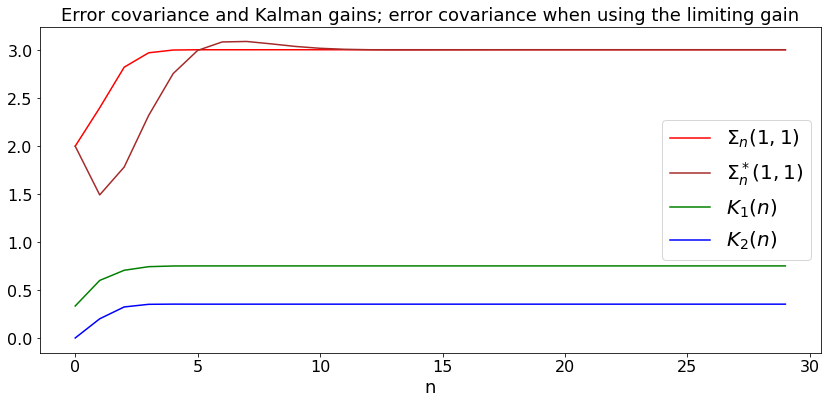

In [10]:
def KF9(v1,v2,w): 
    N = 30
    t = np.arange(0,N)
    sigma = np.arange(0.0,N)
    sigmab = np.arange(0.0,N)
    K1 = np.arange(0.0,N)
    K2 = np.arange(0.0,N)
    C = np.array([[1, 0]])
    S = np.array([[v1, 0],[0,v2]])
    Sb = np.array([[v1, 0],[0,v2]])
    K = np.dot(S,C.transpose())/(S[0,0] + w)
    Kb = np.dot(S,C.transpose())/(S[0,0] + w)
    A = np.array([[1, 1],[0,1]])    
    Sv = np.array([[v1, 0],[0,v2]])
    Sx = S
    Sxb = S
    Sw = w
    sigma[0] = v1
    sigmab[0] = v1
    K1[0] = K[0,0]
    K2[0] = K[1,0]

        
    for k in range(1,N):
        S = np.dot(A,np.dot(Sx, A.T)) + Sv
        K = np.dot(S,C.T)/(S[0,0] + w)
        Sx = np.dot((np.identity(2) - np.dot(K,C)),S) 
        sigma[k] = Sx[0,0]
        K1[k] = K[0]
        K2[k] = K[1]
    Kb = K
    for k in range(1,N):
        Sb = np.dot(A,np.dot(Sxb, A.T)) + Sv
        Sxb = np.dot((np.identity(2) - np.dot(K,C)),Sb) 
        sigmab[k] = Sxb[0,0]
       
    plt.figure(figsize = (14,6))
    pls, = plt.plot(t,sigma,'red',label='$\Sigma_n(1,1)$')
    plt.legend()
    plsb, = plt.plot(t,sigmab,'brown',label='$\Sigma_n^*(1,1)$')
    plt.legend()
    plK1, = plt.plot(t,K1,'green',label='$K_1(n)$')
    plt.legend()
    plK2, = plt.plot(t,K2,'blue', label ='$K_2(n)$')
    plt.legend()
    plt.title('Error covariance and Kalman gains; error covariance when using the limiting gain')
    plt.xlabel('n')
    
KF9(varV1,varV2,varW)
        

## Extended Kalman Filter

Some nonlinear systems behave almost like lineat systems locally in time.  One may then hope that the Kalman filter may provide good estimates in such situations.

To illustrate the ideas, we consider a simple example similar to a random walk, except that the observations are slightly nonlinear.  Specifically, we assume that

$$X(n+1) = 0.9 X(n) + V(n)$$

$$Y(n) = (10 - X(n))^{-2} + W(n).$$


The interpretation is that the object is at $X(n)$ and moves around $0$ while 
being perturbed by $V(n)$.  The observation 
is the power of a radar wave reflected by the object.  The radar is at location $10$.
This power decreases like the square of the distance $|10 - X(n)|$ between the radar and the object.

Assuming that $Z(n) := X(n) - \bar X(n)$ is small, we write

$$Y(n) = (10 - \bar X(n) - Z(n))^{-2} + W(n)$$

$$~~\approx (10 - \bar X(n))^{-2} + 2(10 - \bar X(n))^{-3} Z(n) + W(n)$$

$$~~\approx 10 - \bar X(n))^{-2} + 2(10 - \bar X(n))^{-3} (X(n) - \bar X(n)) + W(n) $$

$$~~\approx (10 - \bar X(n))^{-3}(10 - 3 \bar X(n)) + 2(10 - \bar X(n))^{-3} X(n) + W(n).$$

Thus, assuming the estimates $\bar X(n)$ are fairly accurate, the system is almost linear in the state, but the coefficients depend on the estimate.  This suggests the following Kalman filter:

$$\bar X(n+1) = 0.9 \bar X(n) + K_n[Y(n) - \bar Y(n)] $$

$$\bar Y(n) = (1 - \bar X(n))^{-3}(1 - 3 \bar X(n)) + 1.8(1 - \bar X(n))^{-3} X(n) $$

$$K_n = S_nC_n'[C_nS_nC_n' + \Sigma_W]^{-1}$$

$$S_n = 0.81 \Sigma_{n-1} + \Sigma_V $$

$$\Sigma_n = (I - K_nC_n)S_n $$

$$C_n = 2(1 - \bar X(n))^{-3}.$$

We test this filter in the next code.



In [14]:
def dummy(varVd,varWd):
    global varV, varW
    varV, varW = float(varVd), float(varWd)

varVd = widgets.Dropdown(options=['0', '0.02', '0.04', '0.08','0.1','0.12','0.14','0.16','0.18','0.2','0.22','0.24','0.26','0.28','0.3','0.32','0.34','0.36','0.38','0.4','0.42','0.44','0.46','0.48','0.5','0.52','0.54','0.56','0.58','0.6'],value='0.1',description='varV',disabled=False)
varWd = widgets.Dropdown(options=['0', '0.02', '0.04', '0.08','0.1','0.12','0.14','0.16','0.18','0.2','0.22','0.24','0.26','0.28','0.3','0.32','0.34','0.36','0.38','0.4','0.42','0.44','0.46','0.48','0.5','0.52','0.54','0.56','0.58','0.6'],value='0.2',description='varW',disabled=False)

z = widgets.interactive(dummy, varVd = varVd, varWd = varWd) 
display(z)

interactive(children=(Dropdown(description='varV', index=4, options=('0', '0.02', '0.04', '0.08', '0.1', '0.12…

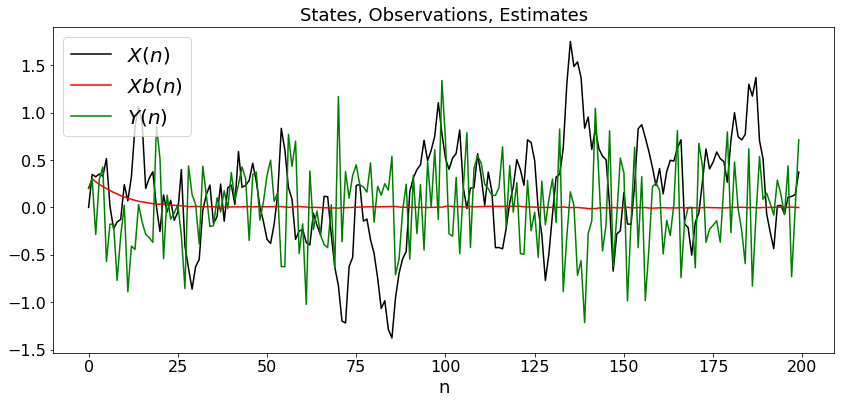

In [15]:
def KF10(v,w):  
    N = 200
    t = np.arange(0,N)
    sigma = np.arange(0.0,N)
    K = np.arange(0.0,N)
    X = np.arange(0.0,N)
    Y = np.arange(0.0,N)
    Xb = np.arange(0.0,N)
    sigma[0] = 0.1
    X[0] = 0.0
    Xb[0] = 0.2
    Xb[1] = 0.3
    Y[0] = 0.2
           
    for n in range(1,N-1):
        X[n] = 0.9*X[n-1] + v**0.5*np.random.normal()
        Y[n] = (10 - X[n])**(-2) + w**0.5*np.random.normal()
        S = 0.81*sigma[n-1] + v
        C = 2*(10 - Xb[n])**(-3)
        K = S*C*(C**2*S + w)**(-1)
        sigma[n] = (1 - K*C)*S
        Yb = (10 - Xb[n])**(-3)*(10 - 3*Xb[n]) + 1.8*(10 - Xb[n])**(-3)*X[n]
        Xb[n+1] = 0.9*Xb[n] + K*(Y[n]-Yb)  
    X[N-1] = 0.9*X[N-2] + v**0.5*np.random.normal()
    Y[N-1] = (10 - X[N-1])**(-2) + w**0.5*np.random.normal()    
    
    plt.figure(figsize = (14,6))
    plX, = plt.plot(t,X,'black',label='$X(n)$')
    plt.legend()
    plXb, = plt.plot(t,Xb,'red',label='$Xb(n)$')
    plt.legend()
    plY, = plt.plot(t,Y,'green',label='$Y(n)$')
    plt.legend()
    plt.title('States, Observations, Estimates')
    plt.xlabel('n')
    
KF10(varV,varW)
        